# RQ1 Which Model is the Best

In [1]:
from DataClean import Data
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data_edit = Data('./data/','edit distance', 'basic', tag=True, data_structure='clean').df

/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Data Merge Finished.


In [7]:
a = data_edit['AAA'].value_counts()
for i, j in a.items():
    print(type(i), j)

<class 'int'> 12386
<class 'int'> 5937
<class 'int'> 1024


In [52]:
def Data_twist(df):
    df = df.fillna(0)
    for i in range(df.shape[0]):
        if df.loc[i,'AAA'] == '1,2':
            df.loc[i,'AAA'] = 2
        elif df.loc[i,'AAA'] == '0,1':
            df.loc[i,'AAA'] = 0
        elif df.loc[i,'AAA'] == '0,2':
            df.loc[i,'AAA'] = 0
        elif df.loc[i,'AAA'] == '0,1,2':
            df.loc[i,'AAA'] = 0
        elif df.loc[i,'AAA'] =='/':
            df.loc[i,'AAA'] = 0
        elif df.loc[i,'AAA'] == np.nan:
            df.loc[i,'AAA'] = 0
    return df

def normalization(df):
    def minmax(group,name):
        scaler = MinMaxScaler()
        return pd.DataFrame(data=scaler.fit_transform(group),columns=group.columns,index=data_edit.loc[data_edit['testClassName'] == name, group.columns].index)
    
    groups = df.drop(labels=['testMethodName','potentialTargetQualifiedName','AAA'], axis=1).groupby('testClassName')
    df_copy = df.copy()
    for name, group in groups:
        group = group.drop(labels=['testClassName'], axis=1)
        group_minmax = minmax(group,name)
        df_copy.loc[df_copy['testClassName'] == name, group.columns] = group_minmax
    return df_copy
    

In [53]:
# fix the multi tagging problem
data_edit = Data_twist(data_edit)
# normalization in each cases
# data_edit = normalization(data_edit)
data_edit

,testClassName,testMethodName,potentialTargetQualifiedName,AAA,Assert Distance,Name Similarity,Tag-Mock,Tag-New,Tag-Test,Tag-Get,Tag-Set
0,IterConfigUtilTest,test5,NEW org.apache.accumulo.core.conf.Configuratio...,0,18.0,5.0,0,1,0,0,0
1,IterConfigUtilTest,test5,org.apache.accumulo.core.conf.ConfigurationCop...,0,17.0,5.0,0,0,0,0,1
2,IterConfigUtilTest,test5,org.apache.accumulo.core.conf.ConfigurationCop...,0,16.0,5.0,0,0,0,0,1
3,IterConfigUtilTest,test5,org.apache.accumulo.core.conf.ConfigurationCop...,0,15.0,5.0,0,0,0,0,1
4,IterConfigUtilTest,test5,NEW org.apache.hadoop.io.Text(S...,0,14.0,5.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
19347,ConsulDynamicConfigurationTest,testGetConfig,ASSERT org.junit.jupiter.api.Assertions.assert...,2,0.0,6.0,0,0,0,0,0
19348,ConsulDynamicConfigurationTest,testGetConfig,org.apache.dubbo.common.config.configcenter.Dy...,1,1.0,4.0,0,0,0,1,0
19349,ConsulDynamicConfigurationTest,testGetConfig,ASSERT org.junit.jupiter.api.Assertions.assert...,2,0.0,6.0,0,0,0,0,0
19350,ConsulDynamicConfigurationTest,testGetConfig,org.apache.dubbo.common.config.configcenter.Dy...,1,1.0,4.0,0,0,0,1,0


# XGboost

Class=0, n=12388 (64.014%)
Class=1, n=1024 (5.291%)
Class=2, n=5940 (30.695%)


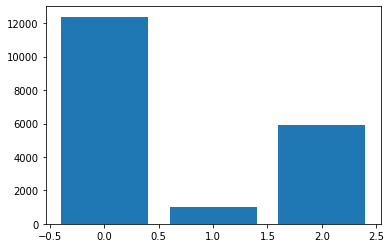

In [54]:
from collections import Counter
y = np.array(data_edit.AAA)

X = np.array(data_edit.drop(labels=['testClassName','testMethodName','potentialTargetQualifiedName','AAA'], axis=1))

counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=100)

dtrain = xgb.DMatrix(data=x_train,label=y_train)
dtest = xgb.DMatrix(data=x_test,label=y_test)

In [56]:
param = {'max_depth':5, 'eta':0.5, 'verbosity':1, 'objective':'multi:softprob', 'num_class':3}
param['nthread'] = 4
param['seed'] = 100
# param['eval_metric'] = 'auc'
# param['eval_metric'] = ['auc', 'ams@0']
# param['eval_metric'] = ['rmse']
# evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 100
bst_without_evallist = xgb.train(param, dtrain, num_round)
# num_round = 10
# bst_with_evallist = xgb.train(param, dtrain, num_round, evallist)


In [57]:
ans = bst_without_evallist.predict(dtest)
prob = np.argmax(ans, axis=1)
print(prob)
print(len(prob))
print(y_test)
print(len(y_test))
def acc(prob, y_test):
    count = 0
    target_count = 0
    target_acc_count = 0
    assert_count = 0
    assert_acc_count = 0
    for _ in range(len(prob)):
        if prob[_] == y_test[_]:
            count += 1
        if prob[_] == y_test[_] and prob[_] == 1:
            target_acc_count += 1
        if y_test[_] == 1:
            target_count +=1
        if prob[_] == y_test[_] and prob[_] == 2:
            assert_acc_count +=1
        if y_test[_] == 2:
            assert_count +=1
    acc = count/len(y_test)
    try:
        action_acc = target_acc_count/target_count
        print("Action Accuracy: {num}".format(num=action_acc))
    except Exception as e:
        print(e)
    # print(assert_count)
    # print(assert_acc_count)
    try:
        assert_acc = assert_acc_count/assert_count
        print("Assert accuracy: {num}".format(num=assert_acc))
    except Exception as e:
        print(e)
    print("accuracy : {num}".format(num=acc)) 
def recall(predict, target):
    
    arrange_TP = 0
    arrange_FN = 0
    action_TP = 0
    action_FN = 0
    assert_TP = 0
    assert_FN = 0

    for _ in range(len(predict)):

        if predict[_] == target[_] and predict[_] == 0:
            arrange_TP += 1
        if predict[_] != target[_] and target[_] != 0:
            arrange_FN +=1
        if predict[_] == target[_] and predict[_] == 1:
            action_TP += 1
        if predict[_] != target[_] and target[_] != 1:
            action_FN +=1
        if predict[_] == target[_] and predict[_] == 2:
            assert_TP += 1
        if predict[_] != target[_] and target[_] != 2:
            assert_FN +=1

    try:
        arrange_recall = arrange_TP/(arrange_TP+arrange_FN)
        print("Arrange Recall: {num}".format(num=arrange_recall))
    except Exception as e:
        print(e)
    # print(assert_count)
    # print(assert_acc_count)
    try:
        action_recall = action_TP/(action_TP+action_FN)
        print("action recall: {num}".format(num=action_recall))
    except Exception as e:
        print(e)
    try:
        assert_recall = assert_TP/(assert_TP+assert_FN)
        print("Assert recall: {num}".format(num=assert_recall))
    except Exception as e:
        print(e)

def percision(predict, target):
    
    arrange_TP = 0
    arrange_FP = 0
    action_TP = 0
    action_FP = 0
    assert_TP = 0
    assert_FP = 0

    for _ in range(len(predict)):

        if predict[_] == target[_] and predict[_] == 0:
            arrange_TP += 1
        if predict[_] != target[_] and target[_] == 0:
            arrange_FP +=1
        if predict[_] == target[_] and predict[_] == 1:
            action_TP += 1
        if predict[_] != target[_] and target[_] == 1:
            action_FP +=1
        if predict[_] == target[_] and predict[_] == 2:
            assert_TP += 1
        if predict[_] != target[_] and target[_] == 2:
            assert_FP +=1

    try:
        arrange_per = arrange_TP/(arrange_TP+arrange_FP)
        print("Arrange per: {num}".format(num=arrange_per))
    except Exception as e:
        print(e)
    # print(assert_count)
    # print(assert_acc_count)
    try:
        action_per = action_TP/(action_TP+action_FP)
        print("action per: {num}".format(num=action_per))
    except Exception as e:
        print(e)
    try:
        assert_per = assert_TP/(assert_TP+assert_FP)
        print("Assert per: {num}".format(num=assert_per))
    except Exception as e:
        print(e)

acc(prob,y_test)
recall(prob,y_test)
percision(prob,y_test)

[0 2 0 ... 0 2 2]
1936
[0 2 0 ... 0 2 2]
1936
Action Accuracy: 0.205607476635514
Assert accuracy: 0.7166947723440135
accuracy : 0.8217975206611571
Arrange Recall: 0.8188976377952756
action recall: 0.07801418439716312
Assert recall: 0.7059800664451827
Arrange per: 0.9255663430420712
action per: 0.205607476635514
Assert per: 0.7166947723440135


# Banlanced

Class=0, n=12388 (33.333%)
Class=1, n=12388 (33.333%)
Class=2, n=12388 (33.333%)


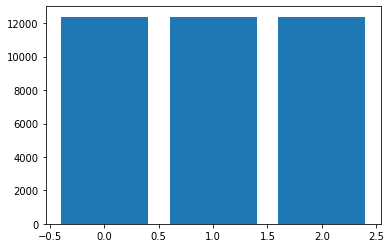

In [58]:
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

# label encode the target variable
y = LabelEncoder().fit_transform(y)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [59]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=100)

dtrain = xgb.DMatrix(data=x_train,label=y_train)
dtest = xgb.DMatrix(data=x_test,label=y_test)

param = {'max_depth':5, 'eta':0.5, 'verbosity':1, 'objective':'multi:softprob', 'num_class':3}
param['nthread'] = 4
param['seed'] = 100
num_round = 100
bst_without_evallist = xgb.train(param, dtrain, num_round)
ans = bst_without_evallist.predict(dtest)
prob = np.argmax(ans, axis=1)
print(prob)
print(len(prob))
print(y_test)
print(len(y_test))
acc(prob,y_test)
recall(prob,y_test)
percision(prob,y_test)

[0 1 1 ... 0 2 1]
3717
[0 1 2 ... 0 2 1]
3717
Action Accuracy: 0.9295659295659295
Assert accuracy: 0.7097032878909383
accuracy : 0.8194780737153619
Arrange Recall: 0.6960651289009498
action recall: 0.6598837209302325
Assert recall: 0.7412060301507538
Arrange per: 0.8214571657325861
action per: 0.9295659295659295
Assert per: 0.7097032878909383


In [60]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


In [61]:
def acc_kf(prob, y_test):
    count = 0
    target_count = 0
    target_acc_count = 0
    assert_count = 0
    assert_acc_count = 0
    for _ in range(len(prob)):
        if prob[_] == y_test[_]:
            count += 1
        if prob[_] == y_test[_] and prob[_] == 1:
            target_acc_count += 1
        if y_test[_] == 1:
            target_count +=1
        if prob[_] == y_test[_] and prob[_] == 2:
            assert_acc_count +=1
        if y_test[_] == 2:
            assert_count +=1
    acc = count/len(y_test)
    try:
        action_acc = target_acc_count/target_count
        print("Action Accuracy: {num}".format(num=action_acc))
    except Exception as e:
        print(e)
    # print(assert_count)
    # print(assert_acc_count)
    try:
        assert_acc = assert_acc_count/assert_count
        print("Assert accuracy: {num}".format(num=assert_acc))
    except Exception as e:
        print(e)
    print("accuracy : {num}".format(num=acc)) 
    
def recall_kf(predict, target):
    
    arrange_TP = 0
    arrange_FN = 0
    action_TP = 0
    action_FN = 0
    assert_TP = 0
    assert_FN = 0

    for _ in range(len(predict)):

        if predict[_] == target[_] and predict[_] == 0:
            arrange_TP += 1
        if predict[_] != target[_] and target[_] != 0:
            arrange_FN +=1
        if predict[_] == target[_] and predict[_] == 1:
            action_TP += 1
        if predict[_] != target[_] and target[_] != 1:
            action_FN +=1
        if predict[_] == target[_] and predict[_] == 2:
            assert_TP += 1
        if predict[_] != target[_] and target[_] != 2:
            assert_FN +=1

    try:
        arrange_recall = arrange_TP/(arrange_TP+arrange_FN)
        # print("Arrange Recall: {num}".format(num=arrange_recall))
    except Exception as e:
        print(e)
    # print(assert_count)
    # print(assert_acc_count)
    try:
        action_recall = action_TP/(action_TP+action_FN)
        # print("action recall: {num}".format(num=action_recall))
    except Exception as e:
        print(e)
    try:
        assert_recall = assert_TP/(assert_TP+assert_FN)
        # print("Assert recall: {num}".format(num=assert_recall))
    except Exception as e:
        print(e)
    return (arrange_recall,action_recall,assert_recall)

def percision_kf(predict, target):
    
    arrange_TP = 0
    arrange_FP = 0
    action_TP = 0
    action_FP = 0
    assert_TP = 0
    assert_FP = 0

    for _ in range(len(predict)):

        if predict[_] == target[_] and predict[_] == 0:
            arrange_TP += 1
        if predict[_] != target[_] and target[_] == 0:
            arrange_FP +=1
        if predict[_] == target[_] and predict[_] == 1:
            action_TP += 1
        if predict[_] != target[_] and target[_] == 1:
            action_FP +=1
        if predict[_] == target[_] and predict[_] == 2:
            assert_TP += 1
        if predict[_] != target[_] and target[_] == 2:
            assert_FP +=1

    try:
        arrange_per = arrange_TP/(arrange_TP+arrange_FP)
        # print("Arrange per: {num}".format(num=arrange_per))
    except Exception as e:
        print(e)
    # print(assert_count)
    # print(assert_acc_count)
    try:
        action_per = action_TP/(action_TP+action_FP)
        # print("action per: {num}".format(num=action_per))
    except Exception as e:
        print(e)
    try:
        assert_per = assert_TP/(assert_TP+assert_FP)
        # print("Assert per: {num}".format(num=assert_per))
    except Exception as e:
        print(e)
    return (arrange_per,action_per,assert_per)

In [62]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True)

# 归一化

scaler = MinMaxScaler()
data_edit_minmax = pd.DataFrame(data=scaler.fit_transform(X))
target_df = pd.DataFrame(data=y)
# data_edit_minmax = pd.DataFrame(data=X)
# target_df = pd.DataFrame(data=y)
# target_df


In [63]:
# XGB
ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        dtrain = xgb.DMatrix(data=x_train,label=y_train)
        dtest = xgb.DMatrix(data=x_test,label=y_test)

        param = {'max_depth':5, 'eta':0.5, 'verbosity':1, 'objective':'multi:softprob', 'num_class':3}
        param['nthread'] = 4
        param['seed'] = 100
        num_round = 100
        bst_without_evallist = xgb.train(param, dtrain, num_round)
        ans = bst_without_evallist.predict(dtest)
        prob = np.argmax(ans, axis=1)
      
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
xgb_result_df = pd.core.frame.DataFrame(dic)
xgb_result_df.to_csv('./RQ1/xgb_result.csv',index=False)


Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [64]:
# RF
from sklearn.ensemble import RandomForestClassifier

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        rf = RandomForestClassifier(oob_score=True)
        rf.fit(x_train, y_train.values.ravel())
        rf_pred = rf.predict(x_test)
   
        prob = rf_pred

        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
rf_result_df = pd.core.frame.DataFrame(dic)
rf_result_df.to_csv('./RQ1/rf_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [65]:
# DT
from sklearn.tree import DecisionTreeClassifier

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        dt = DecisionTreeClassifier()
        dt.fit(x_train, y_train.values.ravel())

        prob = dt.predict(x_test)  
        
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
dt_result_df = pd.core.frame.DataFrame(dic)
dt_result_df.to_csv('./RQ1/dt_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [66]:
# SVM oneVSone
# A=B=C=D=0; # 票数初始化
# (A，B)-classifier 如果是A win，则A=A+1;otherwise, B=B+1;
# (A，C)-classifier 如果是A win，则A=A+1;otherwise, C=C+1;
# …
# (C，D)-classifier 如果是A win，则C=C+1;otherwise, D=D+1;
# The decision is the Max(A，B，C，D)

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        nb = OneVsOneClassifier(SVC())
        nb.fit(x_train,y_train.values.ravel())
        prob = nb.predict(x_test)  

        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
nb_result_df = pd.core.frame.DataFrame(dic)
nb_result_df.to_csv('./RQ1/svm_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [67]:
# LR
from sklearn.linear_model import LogisticRegression

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        lr = LogisticRegression(penalty='l2',solver='newton-cg',multi_class='multinomial')
        lr.fit(x_train, y_train.values.ravel())
        lr_pred = lr.predict(x_test)
        # print(rf_pred)
        prob = lr_pred
        
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
lr_result_df = pd.core.frame.DataFrame(dic)
lr_result_df.to_csv('./RQ1/lr_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [68]:
# BPNN
from sklearn.neural_network import MLPClassifier

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        bpnn = MLPClassifier(solver='adam',alpha=1e-5,hidden_layer_sizes=(7,7,14),activation='relu',max_iter=400)
        bpnn.fit(x_train, y_train.values.ravel())
        bpnn_pred = bpnn.predict(x_test)
        # print(rf_pred)
        prob = bpnn_pred
        
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
bpnn_result_df = pd.core.frame.DataFrame(dic)
bpnn_result_df.to_csv('./RQ1/bpnn_result.csv',index=False)

/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the 

Round 1


/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the 

Round 2
Round 3


/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the 

Round 4


/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Round 5


/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Round 6


/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Round 7


/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Round 8


/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chenhao/Documents/Code/Python/Venv/jpt/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Round 9
Round 10


# F1

In [69]:
## F1 and Avarage and Ttest
### f1 = 2*(precision*recall)/(precision+recall)
from scipy import stats
import os

def gen_p(data1,data2):
    '''data should be numpy array'''
    equal_var = True
    if stats.levene(data1,data2)[1] < 0.05:
        equal_var = False
    return stats.ttest_ind(data1,data2,equal_var)[1]

def gen_f1(p,r):
    return 2*(p*r)/(p+r)

def findAllFile(folder_path):
    for root, ds, fs in os.walk(folder_path):
        for f in fs:
            fullname = os.path.join(root, f)
            yield fullname
########## File list ##############
all_test_file_list = []
all_feature_file_list = []

for i in findAllFile('./RQ1/'):
    if i == './RQ1/.DS_Store': #TODO: need fix
        continue
    else:
        all_test_file_list.append(i)
        print(i)

################### F1 genaration fot all the t-test files ############
for file in all_test_file_list:
    processing_df = pd.read_csv(file)
    processing_df.insert(2,'arrange_f1',0)
    processing_df.insert(5,'action_f1',0)
    processing_df.insert(8,'assert_f1',0)

    for _ in range(100):
        try:
            processing_df.loc[_,'arrange_f1'] = gen_f1(processing_df['arrange_precision'][_],processing_df['arrange_recall'][_])
            processing_df.loc[_,'action_f1'] = gen_f1(processing_df['action_precision'][_],processing_df['action_recall'][_])
            processing_df.loc[_,'assert_f1'] = gen_f1(processing_df['assert_precision'][_],processing_df['assert_recall'][_])
        except Exception as e:
            print(e)
            print()
    
    name = './f1/RQ1/'+file.split('/')[-1]
    processing_df.to_csv(name,index=False)

./RQ1/lr_result.csv
./RQ1/svm_result.csv
./RQ1/dt_result.csv
./RQ1/bpnn_result.csv
./RQ1/rf_result.csv
./RQ1/xgb_result.csv
